In [1]:
import numpy as np
import pandas as pd
import folium
import geopandas as gpd
import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [2]:
# Caricamento del dataset con informazioni sui quartieri
df_districts = pd.read_csv('listings_palermo_with_district.csv')
print(f"Dataset caricato: {len(df_districts)} annunci")
print(f"Colonne disponibili: {df_districts.columns.tolist()}")

Dataset caricato: 5401 annunci
Colonne disponibili: ['Unnamed: 0', 'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', '

In [3]:
# Esplorazione dei dati per prezzo e tipo di proprietà
print("Prime righe del dataset:")
print(df_districts[['price', 'property_type', 'district_area']].head())

print("\nTipi di proprietà unici:")
print(df_districts['property_type'].value_counts())

print("\nQuartieri unici:")
print(df_districts['district_area'].value_counts())

Prime righe del dataset:
       price                      property_type        district_area
0     $95.00                 Entire rental unit                Kalsa
1  $1,157.00  Private room in bed and breakfast          Albergheria
2     $50.00        Private room in rental unit            Resuttana
3     $51.00                       Entire condo  VIII Circoscrizione
4    $140.00                 Entire rental unit             Mondello

Tipi di proprietà unici:
property_type
Entire rental unit                    2376
Entire condo                           906
Entire home                            445
Private room in rental unit            401
Entire vacation home                   310
Private room in bed and breakfast      258
Private room in condo                  178
Entire villa                           147
Entire loft                             92
Private room in home                    44
Tiny home                               32
Private room in vacation home           22
Entir

In [4]:
# Pulizia dei dati del prezzo (rimuovere simboli $ e virgole, convertire a numerico)
df_clean = df_districts.copy()

# Controllo formato della colonna price
print("Esempi di valori nella colonna price:")
print(df_clean['price'].head(10))
print(f"\nTipo di dato attuale: {df_clean['price'].dtype}")

# Se il prezzo è in formato stringa con $, pulirlo
if df_clean['price'].dtype == 'object':
    df_clean['price'] = df_clean['price'].str.replace('$', '').str.replace(',', '')
    df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')

# Rimuovere valori nulli o zero
df_clean = df_clean.dropna(subset=['price', 'property_type', 'district_area'])
df_clean = df_clean[df_clean['price'] > 0]

print(f"\nDataset dopo pulizia: {len(df_clean)} annunci")
print(f"Prezzo minimo: ${df_clean['price'].min():.2f}")
print(f"Prezzo massimo: ${df_clean['price'].max():.2f}")
print(f"Prezzo medio: ${df_clean['price'].mean():.2f}")

Esempi di valori nella colonna price:
0       $95.00
1    $1,157.00
2       $50.00
3       $51.00
4      $140.00
5       $69.00
6       $90.00
7       $54.00
8      $105.00
9       $76.00
Name: price, dtype: object

Tipo di dato attuale: object

Dataset dopo pulizia: 5022 annunci
Prezzo minimo: $12.00
Prezzo massimo: $10000.00
Prezzo medio: $120.51


In [5]:
# Calcolo del prezzo medio per tipo di proprietà e quartiere
price_by_type_district = df_clean.groupby(['property_type', 'district_area'])['price'].mean().reset_index()
price_by_type_district = price_by_type_district.sort_values('price', ascending=False)

print("Prezzo medio per tipo di proprietà e quartiere (top 15):")
print(price_by_type_district.head(15))

# Statistiche generali
print(f"\nNumero totale di combinazioni tipo-quartiere: {len(price_by_type_district)}")
print(f"\nTipi di proprietà più comuni:")
print(df_clean['property_type'].value_counts().head(10))

Prezzo medio per tipo di proprietà e quartiere (top 15):
                         property_type            district_area        price
201                       Entire villa                 Guadagna  5740.000000
202                       Entire villa                    Kalsa  2250.000000
111                       Entire place                La Loggia  1530.000000
231  Private room in bed and breakfast                 Partanna   800.000000
114                 Entire rental unit                  Addaura   782.758621
90                         Entire home      VIII Circoscrizione   598.771429
60                         Entire home              Albergheria   542.157895
78                         Entire home                 Partanna   439.615385
200                       Entire villa                 Cruillas   380.000000
80                         Entire home     Residence Rais Gerbi   360.000000
94                         Entire home                      Zen   317.800000
212                

In [6]:
# Creazione del grafico a barre
# Filtriamo per i tipi di proprietà più comuni per rendere il grafico leggibile
top_property_types = df_clean['property_type'].value_counts().head(5).index
df_plot = df_clean[df_clean['property_type'].isin(top_property_types)]

# Calcolo prezzo medio per i tipi di proprietà principali
price_summary = df_plot.groupby(['property_type', 'district_area'])['price'].agg(['mean', 'count']).reset_index()
price_summary.columns = ['property_type', 'district_area', 'avg_price', 'count']

# Filtriamo solo le combinazioni con almeno 5 annunci per avere dati significativi
price_summary = price_summary[price_summary['count'] >= 5]
price_summary = price_summary.sort_values(['property_type', 'avg_price'], ascending=[True, False])

print(f"Dati filtrati per il grafico: {len(price_summary)} combinazioni")
print("\nPreview dei dati per il grafico:")
print(price_summary.head(10))

Dati filtrati per il grafico: 89 combinazioni

Preview dei dati per il grafico:
   property_type        district_area   avg_price  count
17  Entire condo             Mondello  110.375000      8
1   Entire condo              Addaura  108.166667      6
11  Entire condo    II Circoscrizione  107.647059     17
16  Entire condo            La Loggia  102.353535     99
15  Entire condo                Kalsa   97.762590    139
29  Entire condo     V Circoscrizione   94.600000      5
31  Entire condo              Valdesi   94.000000     14
21  Entire condo             Partanna   89.000000     15
14  Entire condo              Il Capo   85.873786    103
30  Entire condo  VIII Circoscrizione   83.035714    168


<Figure size 1500x1000 with 0 Axes>

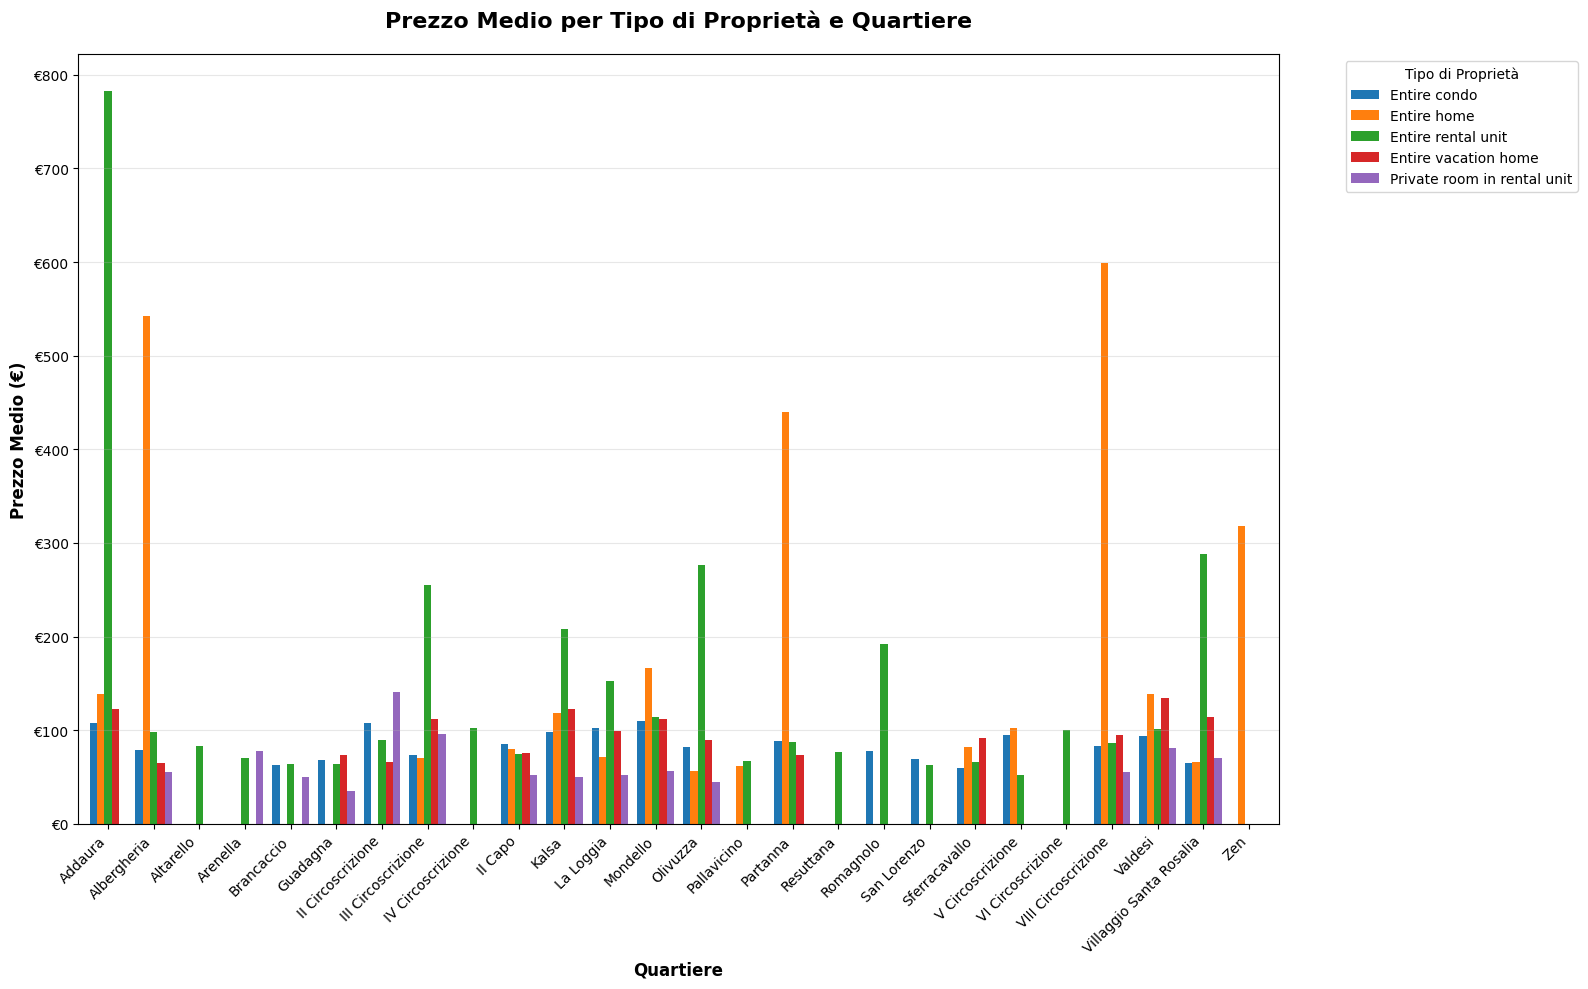


Tabella riassuntiva - Prezzo medio per tipo di proprietà:
Entire home: €193.50
Entire rental unit: €139.71
Entire vacation home: €90.85
Entire condo: €86.48
Private room in rental unit: €59.75


In [7]:
# Creazione del grafico a barre
plt.figure(figsize=(15, 10))

# Preparazione dei dati per il grafico
# Creiamo un grafico raggruppato per tipo di proprietà
width = 0.15
district_areas = price_summary['district_area'].unique()
property_types = price_summary['property_type'].unique()

# Creiamo una matrice per i prezzi
price_matrix = price_summary.pivot(index='district_area', columns='property_type', values='avg_price').fillna(0)

# Grafico a barre raggruppate
ax = price_matrix.plot(kind='bar', figsize=(16, 10), width=0.8)

plt.title('Prezzo Medio per Tipo di Proprietà e Quartiere', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Quartiere', fontsize=12, fontweight='bold')
plt.ylabel('Prezzo Medio (€)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo di Proprietà', bbox_to_anchor=(1.05, 1), loc='upper left')

# Aggiungiamo una griglia per migliorare la leggibilità
plt.grid(True, alpha=0.3, axis='y')

# Formattiamo i valori sull'asse y come euro
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:.0f}'))

plt.tight_layout()
plt.show()

# Stampiamo anche una tabella riassuntiva
print("\nTabella riassuntiva - Prezzo medio per tipo di proprietà:")
avg_by_type = df_plot.groupby('property_type')['price'].mean().sort_values(ascending=False)
for prop_type, avg_price in avg_by_type.items():
    print(f"{prop_type}: €{avg_price:.2f}")